# DC2 Coadd Run1.1p GCR tutorial -- Part II: Lensing Cuts


Owners: **Francois Lanusse [@EiffL](https://github.com/LSSTDESC/DC2_Repo/issues/new?body=@EiffL), Javier Sanchez [@fjaviersanchez](https://github.com/LSSTDESC/DC2_Repo/issues/new?body=@fjaviersanchez)**  
Last Verified to Run: **2018-07-20**

This notebook is the second part of the tutorial [here](DC2%20Coadd%20Run1.1p%20GCR%20tutorial%20--%20Part%20I%3A%20GCR%20Access.ipynb). Here, we present more advanced features of the merged coadd catalogs through the Generic Catalog Reader [GCR](https://github.com/yymao/generic-catalog-reader) and build a lensing sample which we compare to the published [HSC Y1 sample](https://hsc-release.mtk.nao.ac.jp/doc/). The final goal is to show how the different filtering mechanisms, features of `GCR`, and the samples presented here can be useful for your science.

__Learning objectives__:

After going through this notebook, you should be able to:
  1. Select a clean sample of galaxies for weak lensing.
  2. Compute a depth map for a given SNR threshold.
  3. Load both the DC2 Run1.1p catalog and a selection from the HSC Public Data Release XMM field.
  4. Directly access the coadd images to investigate suspicious objects.

__Logistics__: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter-dev.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter-dev+at+NERSC

__Other notes__: This notebook uses the [LSST DM stack](https://pipelines.lsst.io/) (see on the top right corner that we are using the `desc-stack` kernel)

## Selecting a useful sample of galaxies: lensing cuts from HSC DR1

In this notebook, we will build step by step a sample of galaxies from the DC2 run1.1p coadd catalog, and compare it to an equivalent sample built from the HSC DR1 catalog. See more info on [Aihara et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S...8A)

### Sample selection

We will start from a set of basic sanity cuts that will select extended objects and reject problematic sources, including those for which shape measurement has failed.

One subtlety is that shape measurement is only run for the *reference band*, which is most of the time the i-band, but not always, we will further restrict the sample to objects for which we have i-band shapes using the `merge_measurement_i` flag.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import GCRCatalogs
from GCR import GCRQuery
# Load the coadd catalog
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [3]:
basic_cuts = [
    GCRQuery('extendedness > 0'),    # Extended objects
    GCRQuery('merge_measurement_i'), # Select objects for which the reference is the i-band
    
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    ~GCRQuery('xy_flag'),                                       # Flag for bad centroid measurement
    ~GCRQuery('ext_shapeHSM_HsmShapeRegauss_flag'),             # Error code returned by shape measurement code
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_sigma')) # Shape measurement uncertainty should not be NaN
]

In addition to these basic cuts, we will want to apply a set of cuts based on object properties, to ensure we are selecting well resolved and well measured galaxies. One of these properties is the measured total distortion, which is not directly defined in the schema, but can be derived from the measured $e1$, $e2$ distortion components according to $|e| = \sqrt{e_1^2 + e_2^2 }$

The GCR provides a convenience function, `add_quantity_modifier`, to add this quantity to the schema on the fly, so that we can use it afterwards to build our cuts:

In [4]:
# Adds the new derived column 
catalog.add_quantity_modifier('shape_hsm_regauss_etot', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)

# Define lensing cuts on galaxy properties 
properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')       # Shape measurement errors reasonable
]

# We can now extract our lensing sample 
quantities = ['mag_i_cModel', 'snr_i_cModel', 'shape_hsm_regauss_etot', 'ext_shapeHSM_HsmShapeRegauss_resolution']
data_basic = catalog.get_quantities(quantities, 
                           filters=basic_cuts + properties_cuts, 
                           native_filters=['tract == 4849'])

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


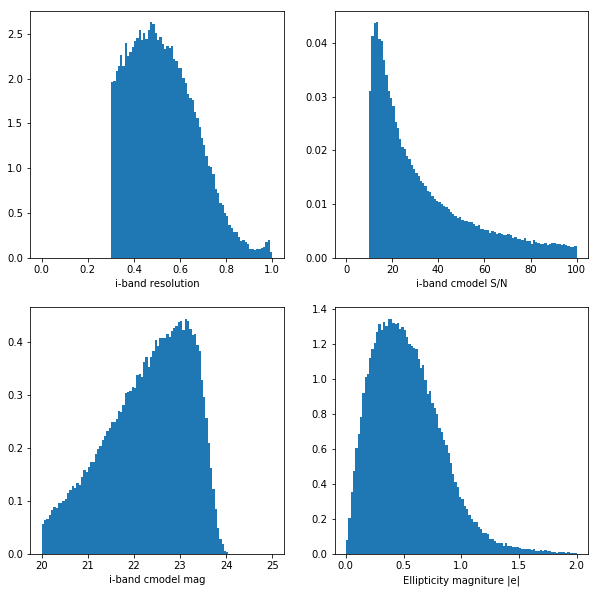

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.hist(data_basic['ext_shapeHSM_HsmShapeRegauss_resolution'], 100, range=[0,1],normed=True);
plt.xlabel('i-band resolution')
plt.xlim()
plt.subplot(222)
plt.hist(data_basic['snr_i_cModel'], 100, range=[0,100],normed=True)
plt.xlabel('i-band cmodel S/N')
plt.subplot(223)
plt.hist(data_basic['mag_i_cModel'], 100, range=[20,25],normed=True);
plt.xlabel('i-band cmodel mag')
plt.subplot(224)
plt.hist(data_basic['shape_hsm_regauss_etot'],100,normed=True);
plt.xlabel('Ellipticity magniture |e|');

You can compare this plot to Fig 12. in [Mandelbaum et al. 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S..25M):
<img src="assets/fig12_mandelbaum2017.png">

A quick visual comparison will highlight two things:

  - We are missing a lot of galaxies between 23 and 24.5 mag
  - We have a bump near resolution of 1

We are going to investigate to understand these differences below.

### Looking at the depth of the survey

One obvious reason why we would be missing some faint galaxies is if DC2 run1.1p is shallower than HSC. We will test this here by measuring the depths of both Run1.1p and the HSC DR1 XMM field. More generally, it is also a concern for most science analysis to have spatially uniform sampled data, which can be checked by looking at the depth of the sample.  

There are several ways to do this, in this case, we are going to check what's the magnitude which has a median SNR closest to 10, the SNR cut of our lensing sample.

In [6]:
import healpy as hp
from cic import binned_statistic  # Import an efficient alternative to binned_statistic_2d, defined in cic.py

def depth_map_snr (ra, dec, mags, snr,snr_threshold=10,nside=2048):
    """
    Constructs a depth map on a healpix grid for a given SNR threshold.
    
    Parameters
    ----------
    ra, dec: Array of coordinates on the sky (in deg.)
    mags, snr : measured magnitude and snr for the sample
    snr_threshold: SNR
    """
    # Remove potentially problematic entries
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    # Create array of healpix pixel indices corresponding to coordinates 
    pix_nums = hp.ang2pix(nside,np.pi/2.-dec[good]*np.pi/180,ra[good]*np.pi/180)
    
    # Create output map
    map_out = np.zeros(12*nside**2)
    
    # Bins in magnitudes
    bin_centers = np.linspace(22+6/30.,28-6/30.,30.)
    
    # For each healpix pixel
    for px in np.unique(pix_nums):
        # Select all objects within this pixel
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            # Compute median snr in bins of magnitude
            median_snr = binned_statistic(mags[mask],snr[mask],np.nanmedian,nbins=30,range=(22,28))
            mask2 = np.isnan(median_snr)==False
            # Find magnitude corresponding to snr threshold
            if np.count_nonzero(mask2)>0:
                depth = bin_centers[mask2][np.argmin(np.fabs(median_snr[mask2] - snr_threshold))]
                map_out[px]=depth
            else:
                map_out[px]=0
        else:
            map_out[px]=0.
    return map_out

In [7]:
quantities = ['ra', 'dec', 'mag_i_cModel', 'snr_i_cModel', 'ext_shapeHSM_HsmShapeRegauss_resolution']

# Data from DC2 run1.1p
data_dc2 = catalog.get_quantities(quantities, 
                                  filters=basic_cuts, # Note the only apply the basic_cuts
                                  native_filters=['tract == 4849'])

# Data from HSC DR1 XMM field 
cat_hsc = GCRCatalogs.load_catalog('hsc-pdr1-xmm')
data_hsc = cat_hsc.get_quantities(quantities,
                                  filters=basic_cuts)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


__Note__: Runtime warning will arise due to objects with incorrect fluxes but the results are unaffected by them.

In [8]:
# Compute i-band depth maps for both surveys
m10map_dc2 = depth_map_snr(data_dc2['ra'],data_dc2['dec'],data_dc2['mag_i_cModel'], data_dc2['snr_i_cModel'])
m10map_hsc = depth_map_snr(data_hsc['ra'],data_hsc['dec'],data_hsc['mag_i_cModel'], data_hsc['snr_i_cModel'])

# Printing the median depth
print("Run1.1p median i-band 10-sigma depth ", np.median(m10map_dc2[m10map_dc2 > 0]))
print("HSC XMM median i-band 10-sigma depth ", np.median(m10map_hsc[m10map_hsc > 0]))

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/ipykernel/__main__.py:23: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:990: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/global/u2/p/pjm43/desc/DC2_Repo/Notebooks/.beavis/DC2_Repo/Notebooks/cic.py:11: RuntimeWarning: invalid value encountered in greater
  mask = (x > r0) &  (x < r1)
/global/u2/p/pjm43/desc/DC2_Repo/Notebooks/.beavis/DC2_Repo/Notebooks/cic.py:11: RuntimeWarning: invalid value encountered in less
  mask = (x > r0) &  (x < r1)


Run1.1p median i-band 10-sigma depth  23.7448275862
HSC XMM median i-band 10-sigma depth  25.2896551724


And now we see the difference between the two samples, HSC is much deeper. This is partly due to the fact that run1.1p was interrupted mid-run so it doesn't reach the full depth of DC2.

### Impact of blendedness
 
The second discrepancy between our sample and the Mandelbaum et al. plot is an excess of galaxies appearing very well resolved compared to the PSF (resolution > 0.9). To understand this difference, we are going to select a few of these objects and extract postage stamps from the DM stack for visual inspection.

We begin by selecting galaxies in our lensing sample which are near perfectly resolved by adding a cut on resolution:

In [9]:
sample_cut = basic_cuts + properties_cuts + [GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.98')]

data = catalog.get_quantities(['ra', 'dec', 'mag_i_cModel', 'ext_shapeHSM_HsmShapeRegauss_resolution'], 
                              filters=sample_cut,
                              native_filters=['tract == 4849'])

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


Now we will extract a few postage stamps at these coordinates, to do so we will reuse some of the code from the [DC2 Postage Stamps tutorial](/DC2%20Postage%20Stamps.ipynb). Please have a look at that tutorial to fully understand the function we will be using here, but in a nustshell we are going to query the DM data Butler to retrieve cutouts of the Deep Coadd exposures of these objects in the i-band.

In [10]:
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

from astropy.table import Table
from astropy.visualization import ZScaleInterval

# Please check the DC2 Postage Stamps tutorial for all the details of how this works
def cutout_coadd_ra_dec(butler, ra, dec, filt='i', datasetType='deepCoadd', 
                                  skymap=None, cutoutSideLength=50, **kwargs):
    """Produce a cutout from a coadd at the given ra,dec coordinates
    

    Parameters
    --
    butler - lsst.daf.persistence.Butler of the data repository
    ra, dec - coordinates of the center of the cutout (in degrees).
    filter - Filter of the image to load
    datasetType - 'deepCoadd'  Which type of coadd to load.  Doesn't support 'calexp'
    
    skymap - [optional] Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength - [optional] Side of the cutout region in pixels.
    
    Returns
    --
    MaskedImage
    """
    # Create a lsst.afw.geom.SpherePoint coordinates object
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("deepCoadd_skyMap")
    
    # Retrieves the tract, patch info for these coordinates from the skymap
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    
    # Get pixel coordinates on the tract
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)

    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filt}
    
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    
    return cutout_image

With this tool to extract cutouts in hand, let's have a look at a few examples in our sample:

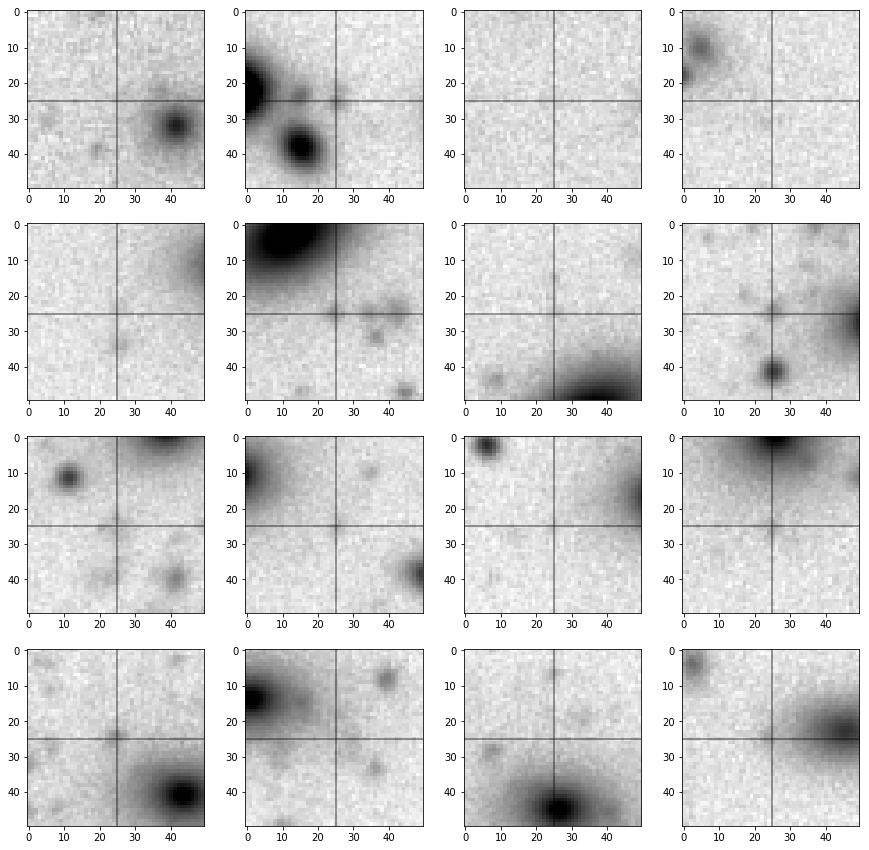

In [11]:
# Create an instance of the data butler for the run 1.1p data repository
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dafPersist.Butler(repo)

plt.figure(figsize=(15,15));
for i in range(16):
    plt.subplot(4,4,i+1)

    # Extract the cutout using the data butler
    cutout_image = cutout_coadd_ra_dec(butler, data['ra'][i], data['dec'][i]);
    
    # Plot the postage stamp on the same scales, with some arcsinh range compression 
    plt.imshow(np.arcsinh(cutout_image.image.array), vmax=4, cmap='binary');
    
    # Let's add a crosshair to guide the eye
    plt.axhline(25, color='k',alpha=0.5)
    plt.axvline(25, color='k',alpha=0.5);

So, one thing may jump to eye, these objects are supposed to be large, extremely well resolved, yet they often look fairly small... but they have a lot of sometimes very bright neighbours. This is very suspicious and may indicate a problem with the DM deblender.

Looking at the [SCHEMA.md](https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs) one may notice a field named `blendedness`. This is a metric produced by the DM stack defined  for deblended objects and "measures the fraction of the total flux in the neighborhood of a source that belongs to its neighbors" [(Bosch et. 2018)](http://adsabs.harvard.edu/abs/2018PASJ...70S...5B).

Let's have a look at the `blendedness` values of the examples in our sample:

In [12]:
data = catalog.get_quantities(['blendedness'], 
                              filters=sample_cut,
                              native_filters=['tract == 4849'])

data['blendedness'][0:16]

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


array([ 0.88319057,  0.99361118,  0.27624278,  0.64823245,  0.80371936,
        0.8758165 ,  0.97429889,  0.95428557,  0.93131232,  0.94756386,
        0.909545  ,  0.89188228,  0.95627037,  0.91296106,  0.98211395,
        0.93157739])

As one would expect, they all have a large values, close to 1, indicating that these objects belong to very blended neighborhoods. Because the deblender seems to be failing for these objects, we can use this metric to try to exclude them from our sample. 

As a matter of fact, this is what was done in the ([Mandelbaum et al., 2018](http://adsabs.harvard.edu/abs/2018PASJ...70S..25M)) paper where an additional cut on blendedness was introduced to guard against deblender failures. 

Let's try to rebuild our sample following the same approach:

In [13]:
properties_cuts = [
    GCRQuery('snr_i_cModel > 10'),                              # SNR > 10
    GCRQuery('mag_i_cModel < 24.5'),                            # cModel imag brighter than 24.5
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3'), # Sufficiently resolved galaxies compared to PSF
    GCRQuery('shape_hsm_regauss_etot < 2'),                     # Total distortion in reasonable range
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),      # Shape measurement errors reasonable
    # New cut on blendedness:
    GCRQuery('blendedness < 10**(-0.375)')                      # Avoid spurious detections and those contaminated by blends
]

quantities = ['mag_i_cModel', 'snr_i_cModel', 'shape_hsm_regauss_etot', 'ext_shapeHSM_HsmShapeRegauss_resolution']
data = catalog.get_quantities(quantities, 
                           filters=basic_cuts + properties_cuts, 
                           native_filters=['tract == 4849'])

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:243: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


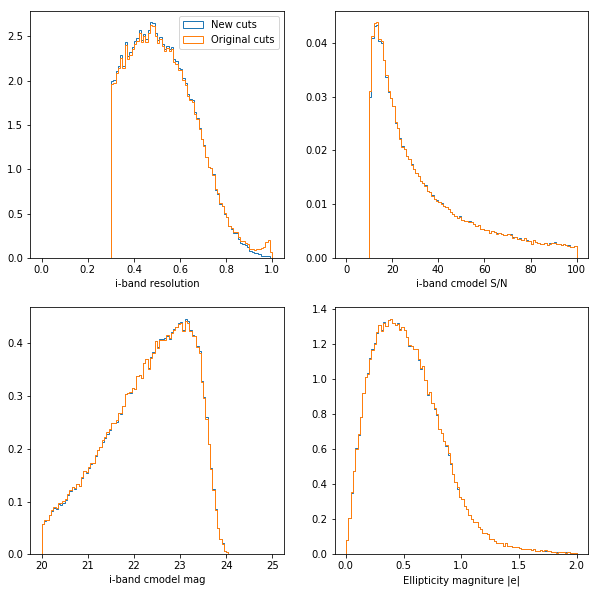

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.hist(data['ext_shapeHSM_HsmShapeRegauss_resolution'], 100, range=[0,1],normed=True, histtype='step', label='New cuts');
plt.xlabel('i-band resolution')
plt.xlim()
plt.subplot(222)
plt.hist(data['snr_i_cModel'], 100, range=[0,100],normed=True, histtype='step', label='New cuts')
plt.xlabel('i-band cmodel S/N')
plt.subplot(223)
plt.hist(data['mag_i_cModel'], 100, range=[20,25],normed=True, histtype='step', label='New cuts');
plt.xlabel('i-band cmodel mag')
plt.subplot(224)
plt.hist(data['shape_hsm_regauss_etot'],100,normed=True, histtype='step', label='New cuts');
plt.xlabel('Ellipticity magniture |e|');
plt.subplot(221)
plt.hist(data_basic['ext_shapeHSM_HsmShapeRegauss_resolution'], 100, range=[0,1],normed=True, histtype='step', label='Original cuts');
plt.xlabel('i-band resolution')
plt.legend(loc='best');
plt.xlim()
plt.subplot(222)
plt.hist(data_basic['snr_i_cModel'], 100, range=[0,100],normed=True, histtype='step', label='Original cuts')
plt.xlabel('i-band cmodel S/N')
plt.subplot(223)
plt.hist(data_basic['mag_i_cModel'], 100, range=[20,25],normed=True, histtype='step', label='Original cuts');
plt.xlabel('i-band cmodel mag')
plt.subplot(224)
plt.hist(data_basic['shape_hsm_regauss_etot'],100,normed=True, histtype='step', label='Original cuts');
plt.xlabel('Ellipticity magniture |e|');

\o/ The excess of high resolution objects has disappeared, mystery solved!

__If you want, you can check out [Part III: Challenges](DC2%20Coadd%20Run1.1p%20GCR%20tutorial%20--%20Part%20III%3A%20Guided%20Challenges.ipynb)!__